In [61]:
import tensorflow as tf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import random
import gzip
import pickle

## Hyperparameters

In [62]:
BETA = 1.1
Z_SIZE = 64
BATCH_SIZE = 128
EPOCHS = 50
E = 1e-10

## Load Voxel-Data

2000
Voxel shape: (16, 16, 16)


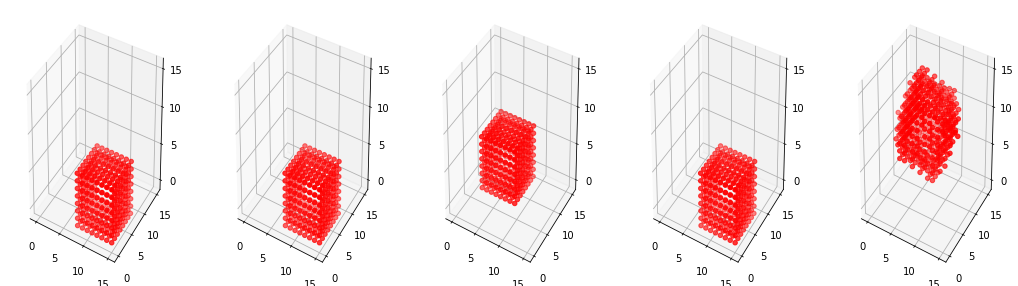

In [64]:
'''
# load .pgz file

#file = 'data/voxel_shapes_len343_ss16_cs10_q0_shift3px.pgz'
file = 'data/voxel_shapes_len729_ss16_cs8_q0_shift4px.pgz'
#file = 'data/voxel_cube_sphere_pen_233829.pgz'

data = None
with gzip.open(file, 'r') as f:
    data = pickle.load(f)
#for k in data.keys():
#    print(k, type(data[k]))


len_data = len(data['voxelShapes'])
len_train = int(len_data*0.8)
random.shuffle(data['voxelShapes'])

X_train = data['voxelShapes'][:len_train]
X_test = data['voxelShapes'][len_train:]
'''

# load data from numpy file
file = 'data/cube_sphere_2000.npy'
data = np.load(file)

len_data = len(data)
len_train = int(len_data*0.8)
random.shuffle(data)
print(len(data))
X_train = data[:len_train]
X_test = data[len_train:]

# show some samples
fig = plt.figure(figsize=(18, 5))
print('Voxel shape:', np.shape(X_train[0]))
for n in range(5):
    ax = plt.subplot(1, 5, n+1, projection='3d')
    ax.set_xlim(-1,16)
    ax.set_ylim(-1,16)
    ax.set_zlim(-1,16)
    #ax = fig.add_subplot(111, projection='3d')
    x = []
    y = []
    z = []
    for i in range(16):
        for j in range(16):
            for k in range(16):
                if X_train[n][i][j][k] == 1:
                    x.append(i)
                    y.append(j)
                    z.append(k)
    
    ax.scatter(x,y,z,c='red')


## beta-VAE-Network

In [65]:
def conv(inputs, filters, kernel_size, strides, activation=tf.nn.relu):
    return tf.layers.conv3d(inputs, filters, kernel_size, strides=strides,
                        padding='SAME', activation=activation)

def deconv(inputs, filters, kernel_size, strides, activation=tf.nn.relu):
    return tf.layers.conv3d_transpose(inputs, filters, kernel_size, strides=strides,
                        padding='SAME', activation=activation)

def sample(mean, std):
    with tf.variable_scope('random_sampling'):
        shape = tf.shape(mean)
        random_sample = tf.random_normal(shape)
        return mean + tf.exp(std * .5) * random_sample
    #noise = np.random.normal(loc=mean, scale=std, size=len(mean)) # * std + mean

## 3D-Convolution

In [66]:
'''
tf.reset_default_graph()

# define variational autoencoder
with tf.variable_scope('Voxel-Input'):
    voxel_input = tf.placeholder(tf.float32, [None, 16, 16, 16, 1])

with tf.variable_scope('Encoder', reuse=tf.AUTO_REUSE):
    encoding = conv(voxel_input, 32, 3, 2)
    encoding = conv(encoding, 64, 3, 2)
    encoding = conv(encoding, 128, 3, 1)
    flatten = tf.layers.flatten(encoding)
    
    z_mean = tf.layers.dense(flatten, Z_SIZE)
    z_std = tf.layers.dense(flatten, Z_SIZE)

with tf.variable_scope('Sample-Encoding'):
    z = sample(z_mean, z_std) 
    z_input = tf.placeholder_with_default(z, [None, Z_SIZE])

with tf.variable_scope('Decoder', reuse=tf.AUTO_REUSE):
    decoding = tf.layers.dense(z_input, 4*4*4*128, activation=tf.nn.relu)
    decoding = tf.reshape(decoding, [-1, 4, 4, 4, 128]) 
    decoding = deconv(decoding, 128, 3, 1)
    decoding = deconv(decoding, 64, 3, 2)
    decoding = deconv(decoding, 32, 3, 2)
    reconstruction = deconv(decoding, 1, 3, 1, activation=tf.nn.sigmoid) 
    
with tf.variable_scope('Loss', reuse=tf.AUTO_REUSE):
    reconstruction_loss = tf.norm(voxel_input - reconstruction, ord='euclidean')
    #reconstruction_loss = tf.losses.mean_squared_error(voxel_input, reconstruction)
    #reconstruction_loss = tf.norm(voxel_input - reconstruction, ord=2)
    kl_divergence = -0.5 * tf.reduce_sum(1.0 + 2.0 * z_std - tf.square(z_mean) - tf.exp(2.0 * z_std), 1)
    loss = tf.reduce_mean(reconstruction_loss + BETA * kl_divergence)
with tf.variable_scope('Train', reuse=tf.AUTO_REUSE):
    train = tf.train.AdamOptimizer(0.0001).minimize(loss)
'''

"\ntf.reset_default_graph()\n\n# define variational autoencoder\nwith tf.variable_scope('Voxel-Input'):\n    voxel_input = tf.placeholder(tf.float32, [None, 16, 16, 16, 1])\n\nwith tf.variable_scope('Encoder', reuse=tf.AUTO_REUSE):\n    encoding = conv(voxel_input, 32, 3, 2)\n    encoding = conv(encoding, 64, 3, 2)\n    encoding = conv(encoding, 128, 3, 1)\n    flatten = tf.layers.flatten(encoding)\n    \n    z_mean = tf.layers.dense(flatten, Z_SIZE)\n    z_std = tf.layers.dense(flatten, Z_SIZE)\n\nwith tf.variable_scope('Sample-Encoding'):\n    z = sample(z_mean, z_std) \n    z_input = tf.placeholder_with_default(z, [None, Z_SIZE])\n\nwith tf.variable_scope('Decoder', reuse=tf.AUTO_REUSE):\n    decoding = tf.layers.dense(z_input, 4*4*4*128, activation=tf.nn.relu)\n    decoding = tf.reshape(decoding, [-1, 4, 4, 4, 128]) \n    decoding = deconv(decoding, 128, 3, 1)\n    decoding = deconv(decoding, 64, 3, 2)\n    decoding = deconv(decoding, 32, 3, 2)\n    reconstruction = deconv(decoding

## Feed-Forward

In [67]:
tf.reset_default_graph()

# define variational autoencoder
with tf.variable_scope('Voxel-Input'):
    voxel_input = tf.placeholder(tf.float32, [None, 16, 16, 16, 1])
    voxel = tf.reshape(voxel_input, [-1, 16*16*16])

with tf.variable_scope('Encoder', reuse=tf.AUTO_REUSE):
    encoding = tf.layers.dense(voxel, 4096, activation=tf.nn.relu)
    encoding = tf.layers.batch_normalization(encoding)
    encoding = tf.layers.dense(encoding, 2048, activation=tf.nn.relu)
    encoding = tf.layers.dense(encoding, 1024, activation=tf.nn.relu)
    
    #z = tf.layers.dense(flatten, Z_SIZE, activation=tf.nn.relu)
    z_mean = tf.layers.dense(encoding, Z_SIZE)
    z_std = tf.layers.dense(encoding, Z_SIZE)

with tf.variable_scope('Sample-Encoding'):
    z = sample(z_mean, z_std) 
    z_input = tf.placeholder_with_default(z, [None, Z_SIZE])
    #tf.cond(training, true_fn=sample(z_mean, z_std), false_fn=z_mean)
    #z_input = tf.placeholder(tf.float32, [None, Z_SIZE, 1])

with tf.variable_scope('Decoder', reuse=tf.AUTO_REUSE):
    decoding = tf.layers.dense(z_input, 1024, activation=tf.nn.relu)
    decoding = tf.layers.dense(decoding, 2048, activation=tf.nn.relu)
    decoding = tf.layers.batch_normalization(decoding)
    decoding = tf.layers.dense(decoding, 4096, activation=tf.nn.sigmoid)
    reconstruction = tf.reshape(decoding, [-1, 16, 16, 16, 1])
    
with tf.variable_scope('Loss', reuse=tf.AUTO_REUSE):
    #reconstruction_loss = tf.norm(voxel - decoding, ord='euclidean')
    #reconstruction_loss = tf.losses.mean_squared_error(voxel, decoding)
    reconstruction_loss = tf.losses.mean_pairwise_squared_error(voxel, decoding)
    #kl_divergence = 0.5 * tf.reduce_sum(tf.square(z_std) + tf.square(z_mean) \
    #                                    - tf.log(E + tf.square(z_std)) - 1, axis=1)
    #kl_divergence = -0.5 * tf.reduce_sum(1.0 + z_std - tf.square(z_mean) - tf.exp(z_std), 1)
    #loss = tf.reduce_mean(reconstruction_loss + BETA * kl_divergence)
    loss = reconstruction_loss
with tf.variable_scope('Train', reuse=tf.AUTO_REUSE):
    b_norm = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(b_norm):
        train = tf.train.AdamOptimizer(0.0001).minimize(loss)


Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


## Tensorboard

In [68]:
tf.summary.scalar('reconstruction_loss/convolutional', tf.reduce_mean(reconstruction_loss))
#tf.summary.scalar('kl_divergence/convolutional', tf.reduce_mean(kl_divergence))
tf.summary.scalar('loss/convolutional', tf.reduce_mean(loss))
tf.summary.scalar('z-mean/convolutional', tf.reduce_mean(z_mean))
tf.summary.scalar('z-std/convolutional', tf.reduce_mean(z_std))
tf.summary.histogram('encoding/convolutional', z_input)
summary = tf.summary.merge_all()

## Training Loop

Finished training epoch 10 with mean loss 3.0807943
Finished training epoch 20 with mean loss 0.92298317
Finished training epoch 30 with mean loss 0.5900263
Finished training epoch 40 with mean loss 0.5327297
Finished training epoch 50 with mean loss 0.46490058


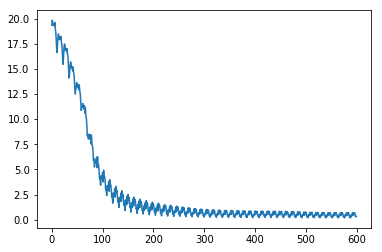

In [69]:
iterations_per_epoch = len(X_train) // BATCH_SIZE
losses = []

sess = tf.Session()

summary_writer = tf.summary.FileWriter('tensorboard', sess.graph)
sess.run(tf.global_variables_initializer())

for e in range(EPOCHS):
    for i in range(iterations_per_epoch):
        batch = X_train[i*BATCH_SIZE : (i+1) * BATCH_SIZE]
        batch = np.expand_dims(batch, 4)
        l, _ = sess.run([loss, train], feed_dict={ voxel_input : batch })
        losses.append(l)
        if i % 10 == 0:
            s = sess.run(summary, feed_dict={ voxel_input : batch })
            summary_writer.add_summary(s, e*iterations_per_epoch+i)
    if (e+1) % 10 == 0:
        print('Finished training epoch', e+1, 'with mean loss', np.mean(losses[-iterations_per_epoch:]))


plt.plot(losses)

## Test on unseen data

Original Voxel Shapes
Reconstructed Voxel Shapes


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


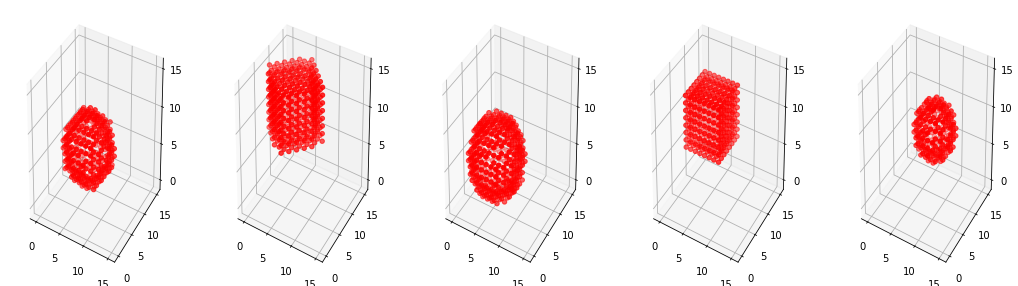

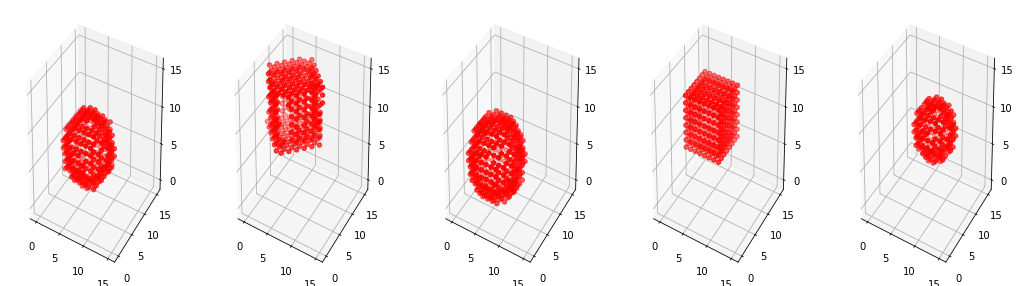

In [70]:
# show some samples
fig = plt.figure(figsize=(18, 5))
print('Original Voxel Shapes')
for n in range(5):
    ax = plt.subplot(1, 5, n+1, projection='3d')
    ax.set_xlim(-1,16)
    ax.set_ylim(-1,16)
    ax.set_zlim(-1,16)
    x = []
    y = []
    z = []
    for i in range(16):
        for j in range(16):
            for k in range(16):
                if X_test[n][i][j][k] == 1:
                    x.append(i)
                    y.append(j)
                    z.append(k)
    
    ax.scatter(x,y,z,c='red')

fig1 = plt.figure(figsize=(18, 5))
print('Reconstructed Voxel Shapes')
for n in range(5):
    
    voxel_ = X_test[n]
    voxel_ = [np.expand_dims(voxel_, 4)]
    reconstr = sess.run(reconstruction, feed_dict={ voxel_input : voxel_ })
    
    ax = plt.subplot(1, 5, n+1, projection='3d')
    ax.set_xlim(-1,16)
    ax.set_ylim(-1,16)
    ax.set_zlim(-1,16)
    #ax = fig.add_subplot(111, projection='3d')
    x = []
    y = []
    z = []
    for i in range(16):
        for j in range(16):
            for k in range(16):
                if reconstr[0][i][j][k] > 0.6:
                    x.append(i)
                    y.append(j)
                    z.append(k)
    
    ax.scatter(x,y,z,c='red')

